# Linear probe on embeddings

In [1]:
# Core Libraries
import os
import glob
import itertools

# Data Handling
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Progress Bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Statistics
from scipy.stats import skew, kurtosis, randint

# Modeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model


In [2]:

static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

static_variables.remove('ICUType')

static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.remove('ICUType')
dyn_variables.append('Weight_VAR')
len(dyn_variables), len(static_variables_we_want)

initial_column_lists = static_variables_we_want + dyn_variables

In [3]:
# open embedding_palib_a.csv in data_4
df_a_emb = pd.read_csv('data_4/embedding_feat_for_a.csv')
df_c_emb = pd.read_csv('data_4/embedding_feat_for_c.csv')
outcomes = pd.read_csv('data/outcomes.csv')

In [4]:
df_a_emb

,RecordID,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,132539.0,-0.012958,-0.025266,0.012520,-0.001375,0.005503,-0.012004,0.014681,0.006238,-0.011897,...,-0.017194,-0.019789,0.005498,-0.013444,-0.008184,0.002417,0.014706,-0.001890,-0.037575,-0.008927
1,132540.0,-0.017817,-0.030658,0.005865,0.005403,0.015092,-0.008452,0.018519,0.010844,-0.010185,...,-0.008239,-0.027246,0.011341,-0.014637,-0.012909,0.015652,0.016735,0.007432,-0.043864,-0.005641
2,132541.0,-0.015878,-0.026322,0.013118,0.003591,0.014589,-0.009240,0.021075,0.011062,-0.012841,...,-0.007274,-0.019533,0.008701,-0.014539,-0.012688,0.011941,0.017263,0.007461,-0.043468,-0.006510
3,132543.0,-0.011936,-0.027855,0.014267,0.001576,0.006452,-0.012533,0.014743,0.007592,-0.017981,...,-0.015046,-0.023605,0.006063,-0.012790,-0.012137,0.013589,0.019739,-0.000626,-0.038308,-0.009191
4,132545.0,-0.007641,-0.023596,0.011013,0.001347,0.008552,-0.010707,0.012390,0.008800,-0.010009,...,-0.019782,-0.021413,0.007266,-0.008309,-0.010286,0.004231,0.010656,-0.005669,-0.040076,-0.014499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665.0,-0.018376,-0.031934,0.015731,0.004010,0.012903,-0.012126,0.011604,0.009187,-0.006025,...,-0.008923,-0.028148,0.007367,-0.013421,-0.010746,0.001819,0.010625,0.007930,-0.045889,-0.004418
3996,142667.0,-0.009730,-0.025776,0.013776,0.001556,0.006456,-0.011007,0.016115,0.011923,-0.012523,...,-0.011706,-0.020652,0.010048,-0.009509,-0.012476,0.010254,0.016382,-0.001982,-0.042375,-0.010276
3997,142670.0,-0.015574,-0.030552,0.009309,0.008621,0.012472,-0.006136,0.015999,0.011753,-0.007887,...,-0.008507,-0.027350,0.011690,-0.012624,-0.011586,0.009292,0.011960,0.004280,-0.045451,-0.001814
3998,142671.0,-0.016314,-0.029802,0.009515,-0.001161,0.012079,-0.010411,0.018202,0.010965,-0.011188,...,-0.005625,-0.024557,0.011749,-0.014760,-0.010418,0.014834,0.018263,0.003683,-0.044175,-0.008821


In [5]:
# df_a_emb
outcomes_a = outcomes[outcomes['RecordID'].isin(df_a_emb['RecordID'])]
outcomes_c = outcomes[outcomes['RecordID'].isin(df_c_emb['RecordID'])]

In [6]:
outcomes_a

,RecordID,In-hospital_death
0,132539,0
1,132540,0
2,132541,0
3,132543,0
4,132545,0
...,...,...
3995,142665,0
3996,142667,0
3997,142670,0
3998,142671,1


In [7]:
# Scaling
# --- scaling Data ---
feature_cols = [col for col in df_a_emb.columns if col != 'RecordID']

scaler = StandardScaler()
scaler.fit(df_a_emb[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a_emb[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c_emb[feature_cols]), columns=feature_cols)


### We try both a balanced and no class weight model

In [8]:
# train logistic regression model on df_a_emb and df_c_emb
logr = linear_model.LogisticRegression(max_iter=1000)
logr_bal = linear_model.LogisticRegression(max_iter = 1000, class_weight='balanced')
# logr = linear_model.LogisticRegression()
logr.fit(df_a_scaled, outcomes_a['In-hospital_death'])
logr_bal.fit(df_a_scaled, outcomes_a['In-hospital_death'])

LogisticRegression(class_weight='balanced', max_iter=1000)

### Display coefficients of logistic regression models

Text(0.5, 1.0, 'Histogram of coefficients of logistic regression model, balanced weights')

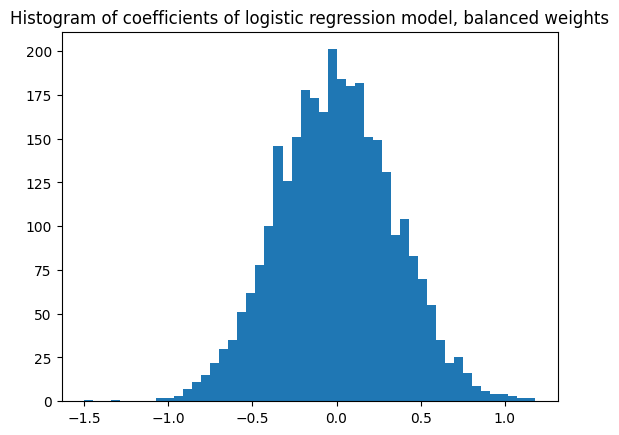

In [9]:

logr_bal.coef_


#  histogram of coefficients of logistic regression model
plt.hist(logr_bal.coef_[0], bins=50)
plt.title('Histogram of coefficients of logistic regression model, balanced weights')



Text(0.5, 1.0, 'Histogram of coefficients of logistic regression model')

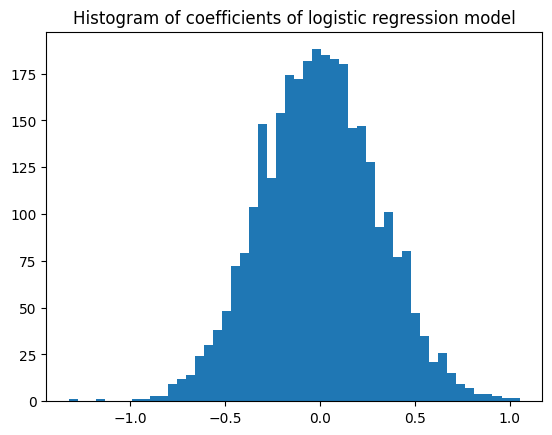

In [10]:
# display coefficients of logistic regression model
logr.coef_


#  histogram of coefficients of logistic regression model
plt.hist(logr.coef_[0], bins=50) 
plt.title('Histogram of coefficients of logistic regression model')



In [11]:
# pred on df_c_emb
pred = logr.predict(df_c_scaled)
pred_proba = logr.predict_proba(df_c_scaled)[:, 1]

pred_bal = logr_bal.predict(df_c_scaled)
pred_proba_bal = logr_bal.predict_proba(df_c_scaled)[:, 1]

ROC AUC Score: 0.615 Average Precision Score: 0.216


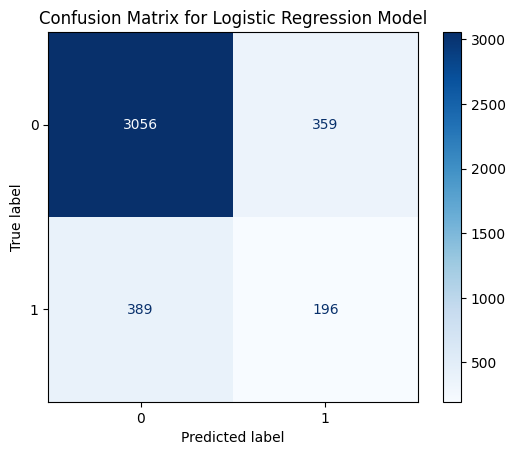

In [12]:
roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred)

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred)
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))

cm = confusion_matrix(outcomes_c['In-hospital_death'], pred, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

ROC AUC Score: 0.631 Average Precision Score: 0.22


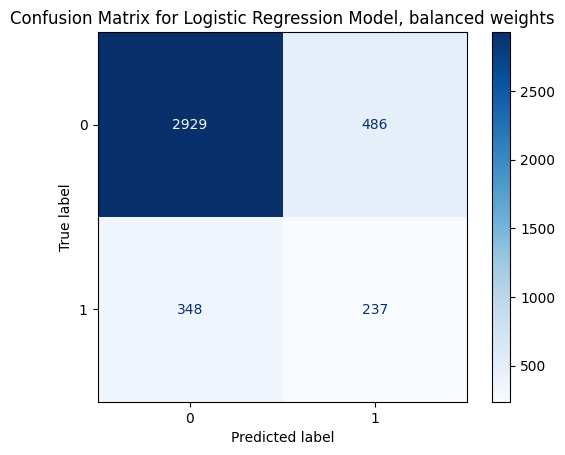

In [13]:
roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred_bal)

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred_bal, )
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))

cm = confusion_matrix(outcomes_c['In-hospital_death'], pred_bal, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model, balanced weights')
plt.show()

### Perform grid search on regularization strengh

In [14]:
param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=600),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc')

In [15]:

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


Best C: 0.01


ROC AUC Score: 0.686 Average Precision Score: 0.25


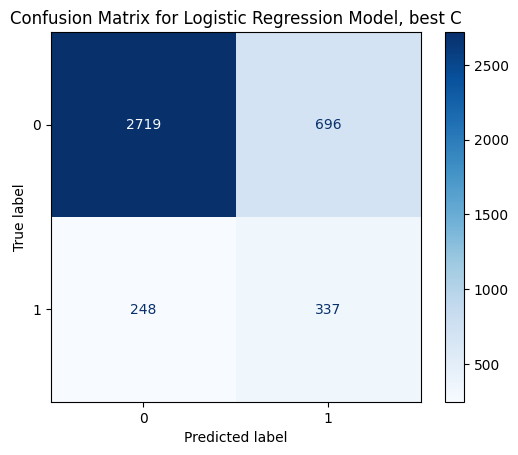

In [16]:
# train on best_log_reg
best_log_reg.fit(df_a_scaled, outcomes_a['In-hospital_death'])
# pred on df_c_emb
pred = best_log_reg.predict(df_c_scaled)
pred_proba = best_log_reg.predict_proba(df_c_scaled)[:, 1]

roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred) 
average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred)
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))
cm = confusion_matrix(outcomes_c['In-hospital_death'], pred, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model, best C')

plt.show()

### TSNE


In [17]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import plotly.express as px

features = df_a_emb.loc[:, '1':'3072']

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

# Create DataFrame with projections + label
df_tsne = pd.DataFrame(projections, columns=['TSNE-1', 'TSNE-2'])
df_tsne['In-hospital_death'] = outcomes_a['In-hospital_death'].values

# Save to CSV (to be plotted later)
df_tsne.to_csv('data_4/df_tsne.csv', index=False)
print("Saved t-SNE projection to csv")


Saved t-SNE projection to csv


In [ ]:

df_tsne = pd.read_csv('data_4/df_tsne.csv')


# plot df_tsne TSNE-1 over TSNE-2, color by In-hospital_death
fig = px.scatter(df_tsne, x='TSNE-1', y='TSNE-2', color='In-hospital_death', title='t-SNE projection of embedding space')
fig.update_traces(marker=dict(size=5), selector=dict(mode='markers'))
fig.update_layout(title_x=0.5, title_y=0.95, title_font=dict(size=20), width=800, height=600)

fig.show()


In [ ]:
embeddings =  df_tsne.values

sil_score = silhouette_score(embeddings, outcomes_a['In-hospital_death'].values)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.003483006451913072
